In [1]:
import xarray as xr
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pysumma as ps
import pysumma.plotting as psp
import warnings

# pysumma has many depreciated packages, this ignores their warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
# for testing 
!echo "paradise_WY24.nc" > forcings/forcing_file_list.txt

In [13]:
executable = 'summa.exe'
filemanager = './model/settings/file_manager.txt'

# Create a pySUMMA simulation object
s = ps.Simulation(executable, filemanager)


# Set the simulation start and end times from forcing file
with open('./forcings/forcing_file_list.txt', 'r') as file:
    # Read the contents
    forcing_file = file.read().replace("'", "")
forcing = xr.open_dataset('./forcings/'+forcing_file.strip(), engine='netcdf4')
time = forcing['time']

dt64 = np.datetime64(time.isel(time=0).values)
dt = pd.to_datetime(dt64)
start = dt.strftime('%Y-%m-%d %H:%M')
dt64 = np.datetime64(time.isel(time=-1).values)
dt = pd.to_datetime(dt64)
end = dt.strftime('%Y-%m-%d %H:%M')

s.manager['simStartTime'] = start
s.manager['simEndTime'] = end

# Add in some additional variables so we can demonstrate plotting capabilities
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerTemp', 'mLayerDepth', 'mLayerHeight',
              'mLayerLiqFluxSoil', 'mLayerVolFracIce', 'mLayerVolFracLiq', 
              'mLayerVolFracWat','mLayerMatricHead', 'iLayerHeight', 'scalarSnowDepth', 'nSnow']

# Create the new variables
for var in layer_vars:
    s.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s.output_control.options])
for var in all_vars:
    s.output_control[var] = output_settings

out_name = os.path.splitext(forcing_file)[0]
# Run the model, specify the output suffix
s.run('local', run_suffix=out_name)

In [14]:
s.status

'Success'

In [39]:
df = pd.read_csv('./snotel_csvs/paradise_WY24.csv', index_col=0, parse_dates=True)

<Axes: xlabel='time'>

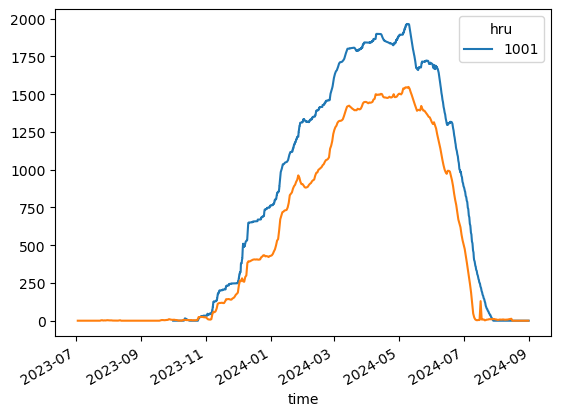

In [40]:
s.output.scalarSWE.to_pandas().plot()
(df['SWE'].resample('1D').mean()*25.4).plot()


In [18]:
s.output

<xarray.Dataset>
Dimensions:                    (time: 8049, hru: 1, gru: 1, midToto: 14,
                                midSoil: 9, ifcToto: 15)
Coordinates:
  * time                       (time) datetime64[ns] 2023-10-01 ... 2024-08-3...
  * hru                        (hru) int64 1001
  * gru                        (gru) int64 1001
Dimensions without coordinates: midToto, midSoil, ifcToto
Data variables: (12/51)
    pptrate                    (time, hru) float64 ...
    airtemp                    (time, hru) float64 ...
    SWRadAtm                   (time, hru) float64 ...
    LWRadAtm                   (time, hru) float64 ...
    averageInstantRunoff       (time, gru) float64 ...
    averageRoutedRunoff        (time, gru) float64 ...
    ...                         ...
    scalarSoilBaseflow         (time, hru) float64 ...
    scalarAquiferBaseflow      (time, hru) float64 ...
    scalarTotalRunoff          (time, hru) float64 ...
    scalarNetRadiation         (time, hru) float64 ...
    hruId                      (hru) int64 1001
    gruId                      (gru) int64 1001
Attributes: (12/34)
    summaVersion:     v3.1.0
    buildTime:        Thu Sep  8 20:31:59 UTC 2022
    gitBranch:        tags/v3.1.0-0-g372c3fb
    gitHash:          372c3fbeb3825e3b3d635461a8e552f9f0895aec
    soilCatTbl:       ROSETTA
    vegeParTbl:       MODIFIED_IGBP_MODIS_NOAH
    ...               ...
    compaction:       anderson
    thCondSnow:       smnv2000
    thCondSoil:       funcSoilWet
    spatial_gw:       localColumn
    subRouting:       timeDlay
    snowDenNew:       pahaut_76